In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Reading in 1/4, 1/8, or 1/16 degree NW2 data:

In [39]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
#run=20; factor = (72/86400) #1/4 degree NeverWorld2 setup, factor is for the e^2 diagnostic which has an error associated with it.
#run=26; factor = (192/86400) #1/8 degree NeverWorld2 setup, factor is for the e^2 diagnostic which has an error associated with it.
run=28; factor = (540/86400) #1/16 degree NeverWorld2 setup,factor is for the e^2 diagnostic which has an error associated with it.
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
init=xr.open_dataset('run%i/MOM_IC.nc'% (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
#print(fs)

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


## For reading in the 1/32 degree NW2 data:

In [3]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=33; factor = 1440/86400 #1/32 degree NeverWorld setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00002000.nc' % (run), decode_times=False)
init=xr.open_dataset('run33/MOM_IC.nc', decode_times=False)
av=xr.open_mfdataset(['run33/averages_00001502.nc','run33/averages_00001602.nc', 'run33/averages_00001702.nc', 'run33/averages_00001802.nc', 'run33/averages_00001902.nc'],decode_times=False,combine='by_coords')
# print(av)
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


## For the GM runs:

In [30]:
#run1 is KHTH=100, run3 is KHTH=500, run5 is KHTH=1000, run6 is KHTH=2500.

%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/runGM/run6
fs=xr.open_dataset('static.nc', decode_times=False)
os=xr.open_dataset('ocean.stats.nc', decode_times=False)
forcing=xr.open_dataset('forcing_00000500.nc', decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

av     = xr.open_dataset('averages_00031502.nc', decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2/runGM/run6
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [40]:
#Read in various grid variables from the static file and forcing:
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']
depthmat = np.tile(depth,[100,15,1,1])
print(depthmat.shape)
area_t=fs['area_t']

xh = fs.xh.values
yh = fs.yh.values

interface_ref=os['H0'].values; interface_ref=interface_ref[-1,:-1]
interface_ref_mat=np.transpose(np.tile(interface_ref,[len(yh),len(xh),100,1]),[2,3,0,1])
print(interface_ref_mat.shape)


Layer = np.array(os['Layer']);
drho=np.zeros(15);
drho[0]=Layer[0]; drho[1:]=np.diff(Layer)
print(drho); #drho contains the density differences across each interface. 15 entries, includes surface but not bottom.
drhomat=np.transpose(np.tile(drho,[len(yh),len(xh),1]),[2,0,1])

(100, 15, 2240, 960)
(100, 15, 2240, 960)
[1.0226e+03 2.1000e-01 3.9000e-01 5.4000e-01 5.8000e-01 5.8000e-01
 5.7000e-01 5.3000e-01 4.8000e-01 4.2000e-01 3.7000e-01 3.1000e-01
 2.4000e-01 1.7000e-01 1.1000e-01]


In [41]:
h = np.array(av['h'][:,:,:,:]); h[np.isnan(h)]=0.0
correction  = (interface_ref_mat-depthmat); #if >0 this means h_ref is deeper than topography, we need correction!
correction[correction<0]=0.0 #if correction <0 that means depth is larger than h_ref, we don't need correction!

interface = np.zeros(h.shape);
for t in range (0,100):
    for i in range(0,len(Layer)):
        interface[t,i,:,:]=((np.nansum(h[t,i:,:,:],axis=0))-depthmat[t,i,:,:])
#interface is negative down, interface_ref_mat is positive down
    print(t)

interface_ref_HIC = interface_ref_mat- correction
eta_mean=np.nanmean((interface+interface_ref_HIC),axis=0)
eta_eddy=(interface+interface_ref_HIC)- eta_mean;

eta2_mean = eta_mean**2.
eta2_eddy = np.nanmean(eta_eddy**2.,axis=0)
print(eta2_mean.shape,eta2_eddy.shape)

APE_mean=np.zeros(eta2_mean.shape);
APE_eddy=np.zeros(eta2_eddy.shape);

for i in range(0,len(interface_ref_mat[0,0,:,0])): #looping over y
    for j in range(0,len(interface_ref_mat[0,0,0,:])): #looping over x
        APE_mean[:,i,j] = 0.5*9.81*drhomat[:,i,j]*eta2_mean[:,i,j]/(1022.6*depthmat[0,:,i,j])
        APE_eddy[:,i,j] = 0.5*9.81*drhomat[:,i,j]*eta2_eddy[:,i,j]/(1022.6*depthmat[0,:,i,j])
APE_mean  =np.nansum(APE_mean,axis=0)#*area_t
APE_eddy  =np.nansum(APE_eddy,axis=0)#*area_t

print('done')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
(15, 2240, 960) (15, 2240, 960)
done


In [42]:
APE_00625= APE_mean
yh_00625 = yh
#APE_GM2500 = APE_mean
#yh_GM2500 = yh

Text(0.5, 1.0, 'Zonally averaged APE')

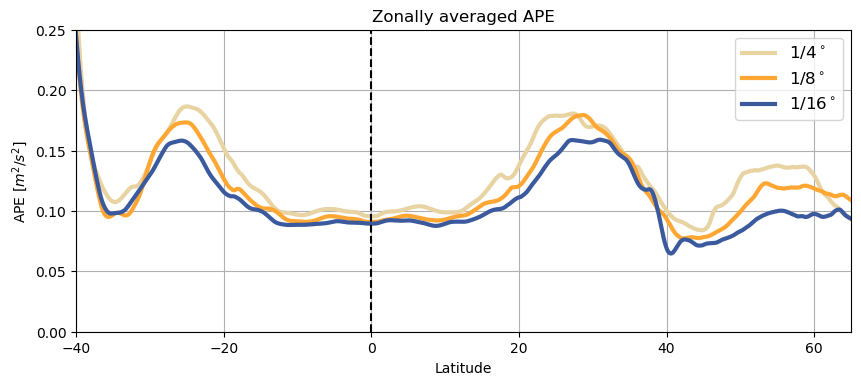

In [49]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,np.nanmean(APE_025,axis=1),'-',c='#e8d3a3',linewidth=3)
plt.plot(yh_0125,np.nanmean(APE_0125,axis=1),'-',c='#ffa633',linewidth=3)
plt.plot(yh_00625,np.nanmean(APE_00625,axis=1),'-',c='#3b5a9d',linewidth=3)
#plt.plot(yh_003125,np.nanmean(APE_003125,axis=1),'-',c='#4fb2aa',linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

plt.legend(['1/4$^\circ$','1/8$^\circ$','1/16$^\circ$'],loc='upper right',fontsize=12)
#plt.legend(['KE_tot 1/4 $^\circ$','KE_tot_ref 1/4$^\circ$','KE_tot 1/16 $^\circ$','KE_tot_ref 1/16$^\circ$'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 10],'--',color=[0,0,0])
plt.xlim(-40,65)

plt.ylim(0,0.25);
plt.xlabel('Latitude')
plt.ylabel('APE [$m^2/s^2$]')
plt.title('Zonally averaged APE')

Text(0.5, 1.0, 'Zonally averaged APE')

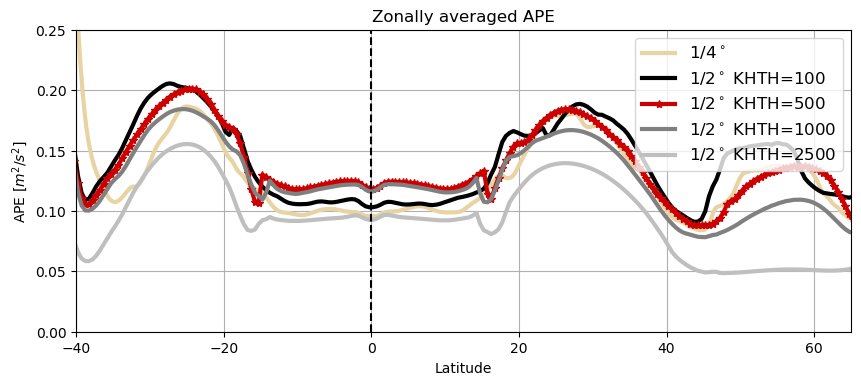

In [48]:

plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,np.nanmean(APE_025,axis=1),'-',c='#e8d3a3',linewidth=3)

plt.plot(yh_GM100,np.nanmean(APE_GM100,axis=1),'-',c=[0, 0, 0],linewidth=3)
plt.plot(yh_GM500,np.nanmean(APE_GM500,axis=1),'-*',c=[.8, 0., 0.],linewidth=3)
plt.plot(yh_GM1000,np.nanmean(APE_GM1000,axis=1),'-',c=[.5, 0.5, 0.5],linewidth=3)
plt.plot(yh_GM2500,np.nanmean(APE_GM2500,axis=1),'-',c=[.75, .75, .75],linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

plt.legend(['1/4$^\circ$','1/2$^\circ$ KHTH=100','1/2$^\circ$ KHTH=500','1/2$^\circ$ KHTH=1000','1/2$^\circ$ KHTH=2500'],loc='upper right',fontsize=12)
#plt.legend(['KE_tot 1/4 $^\circ$','KE_tot_ref 1/4$^\circ$','KE_tot 1/16 $^\circ$','KE_tot_ref 1/16$^\circ$'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 10],'--',color=[0,0,0])

plt.xlim(-40,65)
plt.ylim(0,.25);

plt.xlabel('Latitude')
plt.ylabel('APE [$m^2/s^2$]')
plt.title('Zonally averaged APE')

In [107]:
APE_0125.shape

(1120, 480)

In [53]:
from scipy import interpolate

APE_025_m   = np.nanmean(APE_025,axis=1)
APE_0125_m  = np.nanmean(APE_0125,axis=1)
APE_00625_m = np.nanmean(APE_00625,axis=1)
#APE_003125= np.nanmean(APE_003125_correct,axis=1)

f1 = interpolate.interp1d(yh_0125, APE_0125_m)
f2 = interpolate.interp1d(yh_00625, APE_00625_m)
#f3 = interpolate.interp1d(yh_003125, APE_003125)

APE_0125interp   = f1(yh_025)
APE_00625interp  = f2(yh_025)
#APE_003125interp = f3(yh_025)

frac_025    =APE_025_m/APE_025_m
frac_0125   =APE_0125interp/APE_025_m
frac_00625  =APE_00625interp/APE_025_m
#frac_003125 =APE_003125interp/APE_025
print('done')

done


Text(0.5, 1.0, 'APE relative to 1/4 degree simulation')

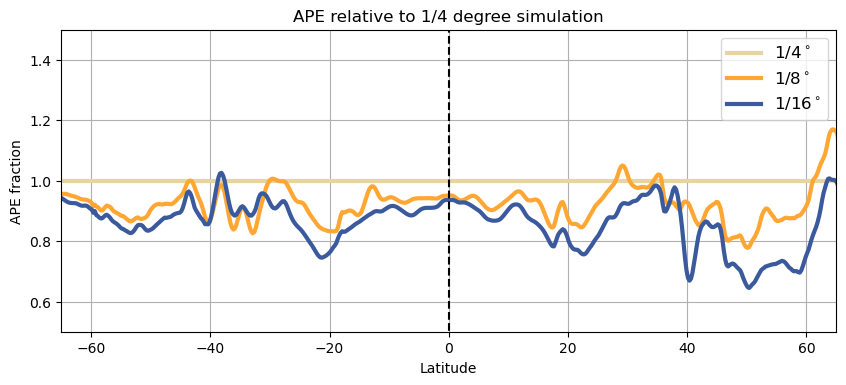

In [54]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_025,frac_025,'-',c='#e8d3a3',linewidth=3)
plt.plot(yh_025,frac_0125,'-',c='#ffa633',linewidth=3)
plt.plot(yh_025,frac_00625,'-',c='#3b5a9d',linewidth=3)
#plt.plot(yh_025,frac_003125,'-',c='#4fb2aa',linewidth=3)


plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

plt.legend(['1/4$^\circ$','1/8$^\circ$','1/16$^\circ$'],loc='upper right',fontsize=12)
#plt.legend(['KE_tot 1/4 $^\circ$','KE_tot_ref 1/4$^\circ$','KE_tot 1/16 $^\circ$','KE_tot_ref 1/16$^\circ$'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 10],'--',color=[0,0,0])
plt.xlim(-65,65)

plt.ylim(0.5,1.5);
plt.xlabel('Latitude')
plt.ylabel('APE fraction')
plt.title('APE relative to 1/4 degree simulation')

### Including the GM runs, KHTH = 100, 500 (suggested value), 1000, 2500 m^2/s. 

In [55]:
from scipy import interpolate

APE_025_m   = np.nanmean(APE_025,axis=1)
APE_GM100_m  = np.nanmean(APE_GM100,axis=1)
APE_GM500_m = np.nanmean(APE_GM500,axis=1)
APE_GM1000_m = np.nanmean(APE_GM1000,axis=1)
APE_GM2500_m = np.nanmean(APE_GM2500,axis=1)

f1 = interpolate.interp1d(yh_025, APE_025_m)
APE_025interp   = f1(yh_GM100)

frac_025      =APE_025interp/APE_025interp
frac_GM100    =APE_GM100_m/APE_025interp
frac_GM500    =APE_GM500_m/APE_025interp
frac_GM1000   =APE_GM1000_m/APE_025interp
frac_GM2500   =APE_GM2500_m/APE_025interp
print('done')

done


Text(0.5, 1.0, 'APE relative to 1/4 degree simulation')

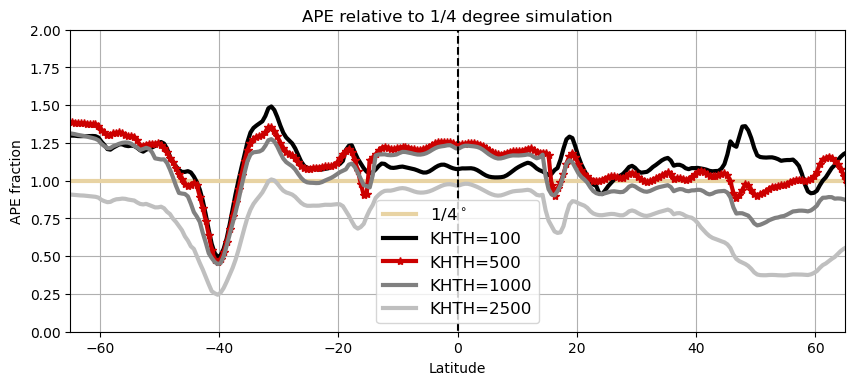

In [57]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_GM100,frac_025,'-',c='#e8d3a3',linewidth=3)
plt.plot(yh_GM100,frac_GM100,'-',c=[0, 0, 0],linewidth=3)
plt.plot(yh_GM500,frac_GM500,'-*',c=[.8, 0., 0.],linewidth=3)
plt.plot(yh_GM1000,frac_GM1000,'-',c=[0.5, 0.5, 0.5],linewidth=3)
plt.plot(yh_GM2500,frac_GM2500,'-',c=[0.75, 0.75, 0.75],linewidth=3)



plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

plt.legend(['1/4$^\circ$','KHTH=100','KHTH=500','KHTH=1000','KHTH=2500'],fontsize=12)
#plt.legend(['KE_tot 1/4 $^\circ$','KE_tot_ref 1/4$^\circ$','KE_tot 1/16 $^\circ$','KE_tot_ref 1/16$^\circ$'],loc='upper right',fontsize=8)
plt.plot([0, 0],[-10, 10],'--',color=[0,0,0])
plt.xlim(-65,65)

plt.ylim(0,2);
plt.xlabel('Latitude')
plt.ylabel('APE fraction')
plt.title('APE relative to 1/4 degree simulation')

In [59]:
from scipy import interpolate

APE_0125_m   = np.nanmean(APE_0125,axis=1)
APE_GM100_m  = np.nanmean(APE_GM100,axis=1)
APE_GM500_m = np.nanmean(APE_GM500,axis=1)
APE_GM1000_m = np.nanmean(APE_GM1000,axis=1)
APE_GM2500_m = np.nanmean(APE_GM2500,axis=1)

f1 = interpolate.interp1d(yh_0125, APE_0125_m)
APE_0125interp   = f1(yh_GM100)

frac_0125      =APE_0125interp/APE_0125interp
frac_GM100    =APE_GM100_m/APE_0125interp
frac_GM500    =APE_GM500_m/APE_0125interp
frac_GM1000   =APE_GM1000_m/APE_0125interp
frac_GM2500   =APE_GM2500_m/APE_0125interp
print('done')

done


Text(0.5, 1.0, 'APE relative to 1/8 degree simulation')

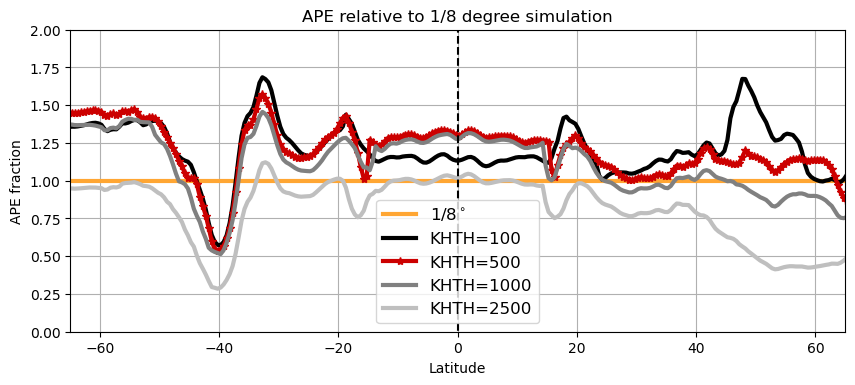

In [60]:
#usually do mean here but trying sum for energetic purposes
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh_GM100,frac_025,'-',c='#ffa633',linewidth=3)
plt.plot(yh_GM100,frac_GM100,'-',c=[0, 0, 0],linewidth=3)
plt.plot(yh_GM500,frac_GM500,'-*',c=[.8, 0., 0.],linewidth=3)
plt.plot(yh_GM1000,frac_GM1000,'-',c=[0.5, 0.5, 0.5],linewidth=3)
plt.plot(yh_GM2500,frac_GM2500,'-',c=[0.75, 0.75, 0.75],linewidth=3)



plt.grid()
#plt.plot(yh_00625,np.convolve(np.nanmean(KE_tot_test_00625,axis=1), np.ones((window,))/window, mode='same'),':',c='k',linewidth=3)

plt.legend(['1/8$^\circ$','KHTH=100','KHTH=500','KHTH=1000','KHTH=2500'],fontsize=12)
#plt.legend(['KE_tot 1/4 $^\circ$','KE_tot_ref 1/4$^\circ$','KE_tot 1/16 $^\circ$','KE_tot_ref 1/16$^\circ$'],loc='upper right',fontsize=8)
plt.plot([0, 0],[-10, 10],'--',color=[0,0,0])
plt.xlim(-65,65)

plt.ylim(0,2);
plt.xlabel('Latitude')
plt.ylabel('APE fraction')
plt.title('APE relative to 1/8 degree simulation')